## Fraud Detection System - Model Research Notebook

---

Most lines of code are explained or links to the references are provided. 

### Imports

In [3]:
import os
import warnings
warnings.filterwarnings('ignore') # ignore warnings so our output isn't cluttered

# --- imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib # saving and loading python objects. we can save large numpy arrays in an optimal way. useful to save our model weights

# LightGBM & XGBoost
import lightgbm as lgb
import xgboost as xgb

### Datasets

In [ ]:
import kagglehub
import zipfile

# Download the dataset first
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print(f"Dataset downloaded to: {dataset_path}")

# List all files in the dataset directory
print("\nFiles in dataset directory:")
for file in os.listdir(dataset_path):
    print(f"  - {file}")

# The creditcard.csv might be compressed or named differently
csv_file = None
zip_file = None

# Look for CSV files or ZIP files
for file in os.listdir(dataset_path):
    if file.endswith('.csv'):
        csv_file = os.path.join(dataset_path, file)
        print(f"Found CSV file: {file}")
        break
    elif file.endswith('.zip'):
        zip_file = os.path.join(dataset_path, file)
        print(f"Found ZIP file: {file}")

# If we found a ZIP file, extract it
if zip_file and not csv_file:
    print(f"\nExtracting ZIP file: {zip_file}")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
        print("Extraction complete!")
        
    # Look for CSV files again after extraction
    for file in os.listdir(dataset_path):
        if file.endswith('.csv'):
            csv_file = os.path.join(dataset_path, file)
            print(f"Found extracted CSV file: {file}")
            break

# Load the CSV file
if csv_file:
    print(f"\nLoading CSV file: {csv_file}")
    try:
        # Try different encodings and parameters
        df = pd.read_csv(csv_file, encoding='utf-8')
        print("✅ Successfully loaded with UTF-8 encoding")
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(csv_file, encoding='latin-1')
            print("✅ Successfully loaded with latin-1 encoding")
        except Exception as e:
            print(f"❌ Failed with latin-1: {e}")
            # Try with more robust settings
            df = pd.read_csv(
                csv_file, 
                encoding='latin-1', 
                engine='python', 
                on_bad_lines='skip'
            )
            print("✅ Successfully loaded with robust settings")
    
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst 5 records:")
    print(df.head())
    
    # Basic info about the dataset
    print(f"\nDataset info:")
    print(f"- Shape: {df.shape}")
    print(f"- Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    if 'Class' in df.columns:
        print(f"- Fraud cases: {df['Class'].sum()}")
        print(f"- Normal cases: {len(df) - df['Class'].sum()}")
        print(f"- Fraud percentage: {df['Class'].mean()*100:.3f}%")

else:
    print("❌ No CSV file found in the dataset!")
    print("Available files:", os.listdir(dataset_path))

100%|██████████| 66.0M/66.0M [00:06<00:00, 11.1MB/s]

Extracting files...


Dataset downloaded to: C:\Users\Dhruv\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3

Files in dataset directory:
  - creditcard.csv
Found CSV file: creditcard.csv

Loading CSV file: C:\Users\Dhruv\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3\creditcard.csv
✅ Successfully loaded with UTF-8 encoding

Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First 5 records:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.2376

The dataset contains 284,807 transactions out of which only 492 are cases of fraud. This is a highly unbalanced dataset so we can not use metrics like simple accuracy or AUC ROC. We will have to focus on False Negatives (transactions that were frauds but were classified as 'not fraud').

---

There are 31 features out of which 3 are revealed to us, `Time`, `Amount` and `Class`. The other 28 features are hidden due to privacy reasons, what we see are the dimensionally reduced principal components. We will use this structured data to predict whether a transaction is a fraud or not using LightGBM, XGBoost and Logistic Regression. 

In [18]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Exploratory Data Analysis

Let's create a directory `models` to save our models after training so we can use them without delay in the real-time fraud detection system.

In [19]:
MODELS_DIR = 'models'
os.makedirs(MODELS_DIR, exist_ok=True)

Functions to make and save plots.

In [20]:
def save_fig(fig, name, dpi=150):
    out = os.path.join('outputs', name)
    os.makedirs('outputs', exist_ok=True)
    fig.savefig(out, bbox_inches='tight', dpi=dpi)


def plot_class_distribution(y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    counts = pd.Series(y).value_counts().sort_index()
    labels = ['Non-fraud (0)', 'Fraud (1)']
    ax.bar(range(len(counts)), counts.values)
    ax.set_xticks([0,1]); ax.set_xticklabels(labels)
    ax.set_yscale('log')
    ax.set_ylabel('Count (log scale)')
    ax.set_title('Class distribution (log scale)')
    return ax


def plot_amount_distribution(df):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].hist(df['Amount'], bins=100); axes[0].set_title('Amount (raw)')
    axes[1].hist(np.log1p(df['Amount']), bins=100); axes[1].set_title('Log(Amount + 1)')
    return fig


def plot_time_by_class(df, bins=100):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(df[df['Class']==0]['Time'], bins=bins, alpha=0.6, label='Non-fraud')
    ax.hist(df[df['Class']==1]['Time'], bins=bins, alpha=0.6, label='Fraud')
    ax.set_title('Transaction Time (seconds since first transaction)')
    ax.legend()
    return fig


def precision_recall_summary(y_true, y_scores, plot=True, name=None):
    ap = average_precision_score(y_true, y_scores)
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    if plot:
        fig, ax = plt.subplots(figsize=(6,5))
        ax.plot(recall, precision, lw=2)
        ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall curve (AP={ap:.4f})')
        if name:
            save_fig(fig, name)
    return ap, precision, recall, thresholds

Basic EDA to see some statistics about the dataset and plot some histograms.


--- Basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  flo

<Figure size 640x480 with 0 Axes>

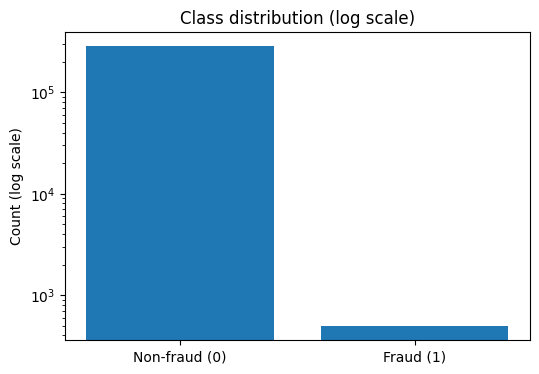

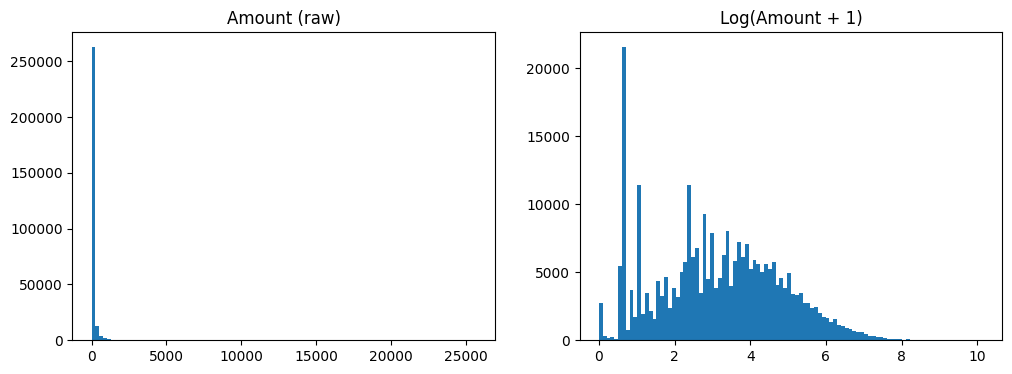

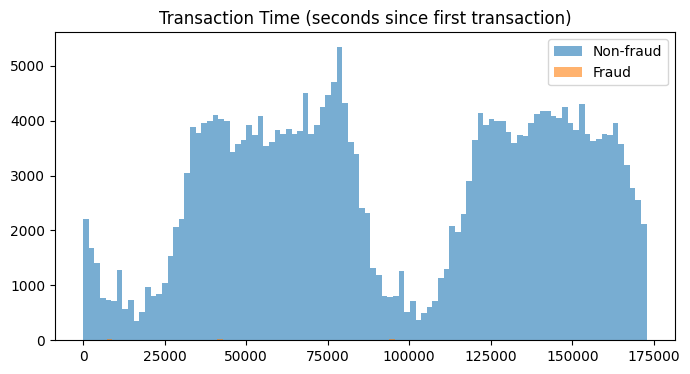

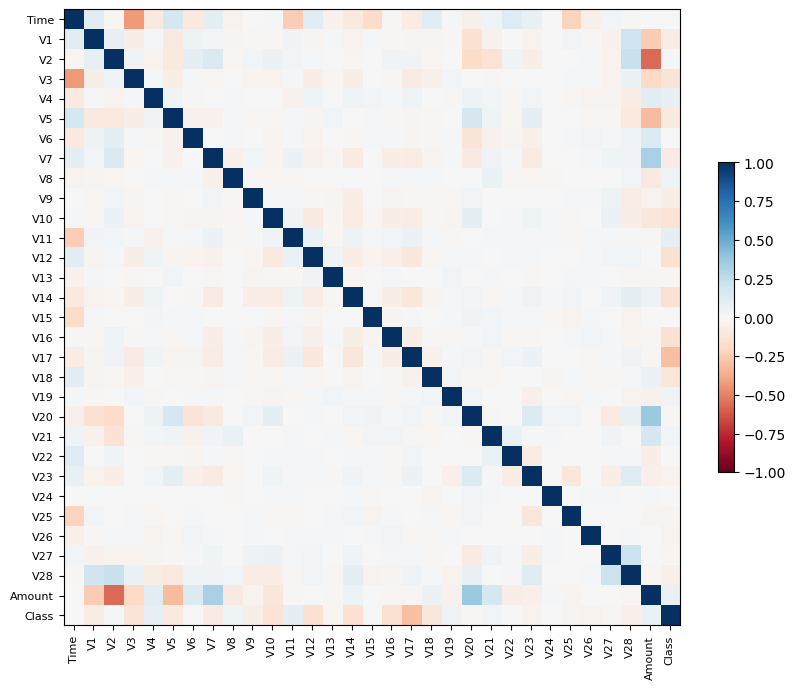

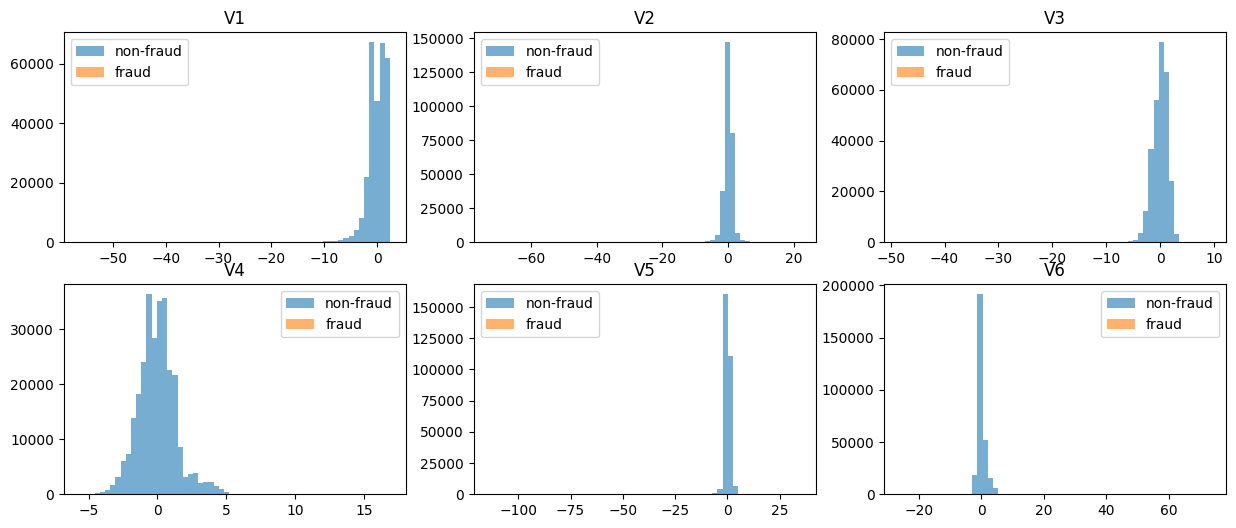

In [21]:
# Basic info
print('\n--- Basic info ---')
print(df.info())

# ---------------------------
# EDA
# ---------------------------

print('\n=== EDA ===')
print('\nClass distribution:')
print(df['Class'].value_counts())

# class balance
n_total = len(df)
n_fraud = df['Class'].sum()
print(f"Total: {n_total}, Fraud: {n_fraud}, ratio: {n_fraud/n_total:.6f}")

# Plot class distribution
fig = plt.figure()
plot_class_distribution(df['Class'])
save_fig(fig, 'class_distribution.png')

# Amount distribution
fig = plot_amount_distribution(df)
save_fig(fig, 'amount_distribution.png')

# Time distribution by class
fig = plot_time_by_class(df)
save_fig(fig, 'time_by_class.png')

# Correlation heatmap for a sample
corr_sample = df.sample(min(5000, len(df)), random_state=42).corr()
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(corr_sample, cmap='RdBu', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_sample.columns)))
ax.set_xticklabels(corr_sample.columns, rotation=90, fontsize=8)
ax.set_yticks(range(len(corr_sample.columns)))
ax.set_yticklabels(corr_sample.columns, fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.02)
save_fig(fig, 'correlation_sample.png')

# Distribution of PCA features for fraud vs non-fraud
pca_cols = [c for c in df.columns if c.startswith('V')]
show_cols = pca_cols[:6]
fig, axes = plt.subplots(2,3, figsize=(15,6))
for i, col in enumerate(show_cols):
    ax = axes.flatten()[i]
    ax.hist(df[df['Class']==0][col], bins=60, alpha=0.6, label='non-fraud')
    ax.hist(df[df['Class']==1][col], bins=60, alpha=0.6, label='fraud')
    ax.set_title(col)
    ax.legend()
save_fig(fig, 'pca_feature_dists.png')

print('EDA plots saved to outputs/')

### Dataset Split

In [22]:
# Features & target
X = df.drop(columns=['Class'])
y = df['Class'].values

# Log transform
X = X.copy()
X['Amount_log'] = np.log1p(X['Amount'])
X = X.drop(columns=['Amount'])

# Optional: scale Time and Amount_log
scaler = StandardScaler()
X[['Time', 'Amount_log']] = scaler.fit_transform(X[['Time', 'Amount_log']])

# Final feature matrix
feature_cols = X.columns.tolist()
print('Feature columns count:', len(feature_cols))

# Train / test split stratified, 80% training, 20% validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Save scaler and column list
joblib.dump(scaler, os.path.join(MODELS_DIR, 'scaler.joblib')) # save scaled features
pd.Series(feature_cols).to_csv(os.path.join(MODELS_DIR, 'feature_cols.csv'), index=False) # save features as csv after EDA

Feature columns count: 30
Train shape: (227845, 30) Test shape: (56962, 30)


### Models

#### Logistic Regression

---

This is not the best idea because logistic regression will learn to just predict 'not fraud' for all cases and give high accuracy when in fact the number of False Negatives for Logistic Regression will be really high as you will see below. 

- `class_weights` parameter here is important as it makes the model penalize misclassifying the minority class. If 'fraud' is 1% of the dataset then its weight will be 99x the weight of 'not fraud'.
- `solver` parameter decides how the coefficients will be optimized for MLE. *saga* has Elastic Net penalty which is better than just L1 or just L2. 


Training baseline LogisticRegression (class_weight="balanced")...
LogisticRegression ROC-AUC: 0.9709, AP: 0.7183

Fraud cases in Training: 365/394 correctly predicted
Fraud cases in Testing: 90/98 correctly predicted


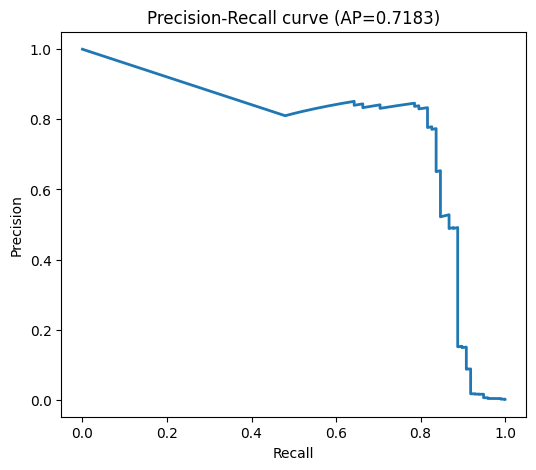

In [23]:
print('\nTraining baseline LogisticRegression (class_weight="balanced")...')
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')
clf_lr.fit(X_train, y_train)

# Predict probabilities
y_pred_proba_lr = clf_lr.predict_proba(X_test)[:, 1]
roc_lr = roc_auc_score(y_test, y_pred_proba_lr)
ap_lr = average_precision_score(y_test, y_pred_proba_lr)
print(f'LogisticRegression ROC-AUC: {roc_lr:.4f}, AP: {ap_lr:.4f}')

# Save model
joblib.dump(clf_lr, os.path.join(MODELS_DIR, 'logistic_baseline.joblib'))w

# Precision-recall plot
precision_recall_summary(y_test, y_pred_proba_lr, plot=True, name='pr_lr.png')

# ----------------------
# ✅ Fraud detection counts
# ----------------------
# Training set
y_train_pred = clf_lr.predict(X_train)
fraud_train_total = (y_train == 1).sum()
fraud_train_correct = ((y_train == 1) & (y_train_pred == 1)).sum()

# Testing set
y_test_pred = clf_lr.predict(X_test)
fraud_test_total = (y_test == 1).sum()
fraud_test_correct = ((y_test == 1) & (y_test_pred == 1)).sum()

print(f"\nFraud cases in Training: {fraud_train_correct}/{fraud_train_total} correctly predicted")
print(f"Fraud cases in Testing: {fraud_test_correct}/{fraud_test_total} correctly predicted")


Logistic Regression is pretty decent.

#### LightGBM

---

Parameters:

- `boosting_type`: you have `dart` that works like dropout in MLP models. It randomly drops trees to help generalize better. There's also `goss` which works well for imbalanced data but it did not work well here. The final is the default `gdbt` which is normal gradient boosting trees. 
- `num_leaves` and `max_depth`: control the complexity of the model. Usually number of leaves is 2^(max_depth) and I kept the depth less than 10 to avoid overfitting.

There's also an early stopping parameter which tracks auc as a patience count.


Training LightGBM with Stratified KFold...
LightGBM Fold 1/5
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.993651	training's aucpr: 0.882336	valid_1's auc: 0.888279	valid_1's aucpr: 0.445984
[200]	training's auc: 0.922079	training's aucpr: 0.906362	valid_1's auc: 0.867395	valid_1's aucpr: 0.4544
Early stopping, best iteration is:
[1]	training's auc: 0.981918	training's aucpr: 0.85848	valid_1's auc: 0.948541	valid_1's aucpr: 0.825119
LightGBM Fold 2/5
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.999997	training's aucpr: 0.994202	valid_1's auc: 0.826033	valid_1's aucpr: 0.653133
[200]	training's auc: 1	training's aucpr: 1	valid_1's auc: 0.831828	valid_1's aucpr: 0.665948
Early stopping, best iteration is:
[1]	training's auc: 0.986671	training's aucpr: 0.871372	valid_1's auc: 0.930537	valid_1's aucpr: 0.786281
LightGBM Fold 3/5
Training until validation scores don't improve for 200 rounds
[100]	training's au

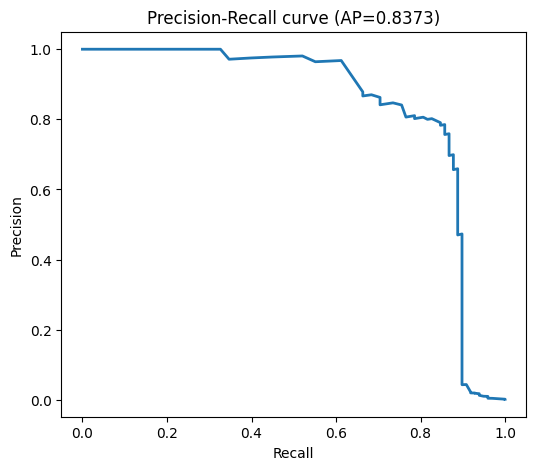

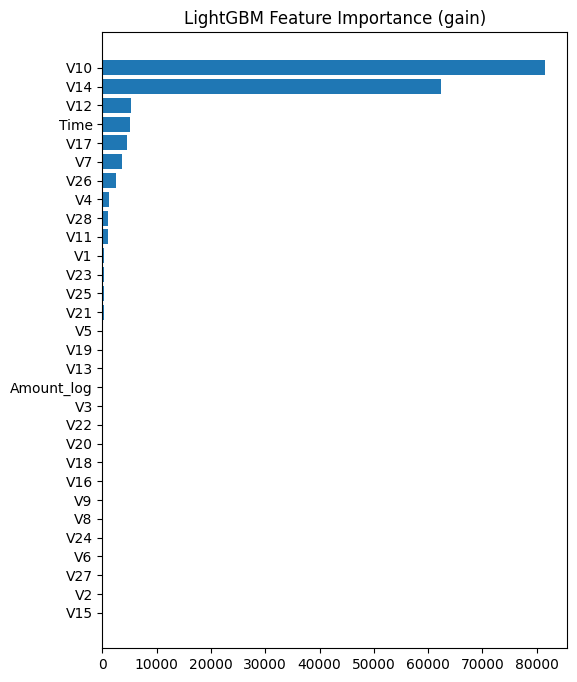

In [43]:
print('\nTraining LightGBM with Stratified KFold...')
from sklearn.metrics import average_precision_score

# custom PR-AUC function
def lgb_pr_auc(y_pred, train_data):
    y_true = train_data.get_label()
    return 'aucpr', average_precision_score(y_true, y_pred), True

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 128,
    'max_depth': 7,
    'seed': 42,
    'verbosity': -1,
}

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

lgb_oof = np.zeros(len(X_train))
lgb_preds = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'LightGBM Fold {fold+1}/{folds}')
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    train_set = lgb.Dataset(X_tr, label=y_tr)
    val_set = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        lgb_params,
        train_set,
        num_boost_round=2500,
        valid_sets=[train_set, val_set],
        feval=lgb_pr_auc,
        callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=100)],
    )

    lgb_oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    lgb_preds += model.predict(X_test, num_iteration=model.best_iteration) / folds

# -------------------
# Metrics
# -------------------
# OOF metrics
roc_oof = roc_auc_score(y_train, lgb_oof)
ap_oof = average_precision_score(y_train, lgb_oof)
print(f'LightGBM OOF ROC-AUC: {roc_oof:.4f}, AP: {ap_oof:.4f}')

# Test metrics
roc_test = roc_auc_score(y_test, lgb_preds)
ap_test = average_precision_score(y_test, lgb_preds)
print(f'LightGBM Test ROC-AUC: {roc_test:.4f}, AP: {ap_test:.4f}')

# -------------------
# ✅ Fraud detection counts
# -------------------
# Threshold probabilities at 0.5 (can tune this later)
y_train_pred = (lgb_oof >= 0.5).astype(int)
y_test_pred = (lgb_preds >= 0.5).astype(int)

# Training fraud counts
fraud_train_total = (y_train == 1).sum()
fraud_train_correct = ((y_train == 1) & (y_train_pred == 1)).sum()

# Testing fraud counts
fraud_test_total = (y_test == 1).sum()
fraud_test_correct = ((y_test == 1) & (y_test_pred == 1)).sum()

print(f"\nFraud cases in Training: {fraud_train_correct}/{fraud_train_total} correctly predicted")
print(f"Fraud cases in Testing: {fraud_test_correct}/{fraud_test_total} correctly predicted")

# -------------------
# Save final model (retrain on full train set)
# -------------------
final_lgb = lgb.train(
    lgb_params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=int(model.best_iteration * 1.0)
)
final_lgb.save_model(os.path.join(MODELS_DIR, 'lightgbm_full.txt'))

precision_recall_summary(y_test, lgb_preds, plot=True, name='pr_lgb.png')

# Feature importance
fi = pd.DataFrame({'feature': feature_cols, 'importance': final_lgb.feature_importance(importance_type='gain')})
fi = fi.sort_values('importance', ascending=False).head(30)
fig, ax = plt.subplots(figsize=(6,8))
ax.barh(fi['feature'][::-1], fi['importance'][::-1])
ax.set_title('LightGBM Feature Importance (gain)')
save_fig(fig, 'lgb_feature_importance.png')


Reason why LightGBM doesn't work that well. 
- Internally, it tracks AUC metric for early stopping and also to find the best iteration. But since this dataset is highly imbalanced, AUC doesn't really work well. Switching to area under precision-recall curve improves the model by 4.6% on testing.

---

At the end we retrain on the full dataset with a cap of the best iteration we found in the k-fold cross-validation. We want our final model to see as much data as possible before deployment. 


Training XGBoost with Stratified KFold...
XGBoost Fold 1/5
[0]	train-auc:0.95748	train-pr_auc:0.14647	valid-auc:0.96519	valid-pr_auc:0.13964
[99]	train-auc:0.99569	train-pr_auc:0.87888	valid-auc:0.98432	valid-pr_auc:0.86047
XGBoost Fold 2/5
[0]	train-auc:0.95220	train-pr_auc:0.14471	valid-auc:0.91462	valid-pr_auc:0.15205
[100]	train-auc:0.99667	train-pr_auc:0.89061	valid-auc:0.97157	valid-pr_auc:0.80945
XGBoost Fold 3/5
[0]	train-auc:0.95967	train-pr_auc:0.23660	valid-auc:0.93364	valid-pr_auc:0.23645
[100]	train-auc:0.99563	train-pr_auc:0.88986	valid-auc:0.97984	valid-pr_auc:0.80391
XGBoost Fold 4/5
[0]	train-auc:0.95909	train-pr_auc:0.14244	valid-auc:0.95944	valid-pr_auc:0.15823
[100]	train-auc:0.99524	train-pr_auc:0.88567	valid-auc:0.98692	valid-pr_auc:0.81971
XGBoost Fold 5/5
[0]	train-auc:0.95968	train-pr_auc:0.14803	valid-auc:0.93867	valid-pr_auc:0.13469
[100]	train-auc:0.99628	train-pr_auc:0.88917	valid-auc:0.97697	valid-pr_auc:0.82743
XGBoost OOF ROC-AUC: 0.9790, AP: 0.8169
XGB

(0.853813135891385,
 array([0.00172045, 0.00177494, 0.00177517, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.02040816, 0.01020408,
        0.        ]),
 array([6.63302722e-04, 6.63322484e-04, 6.63336454e-04, ...,
        6.88837200e-01, 6.90281257e-01, 6.93677396e-01]))

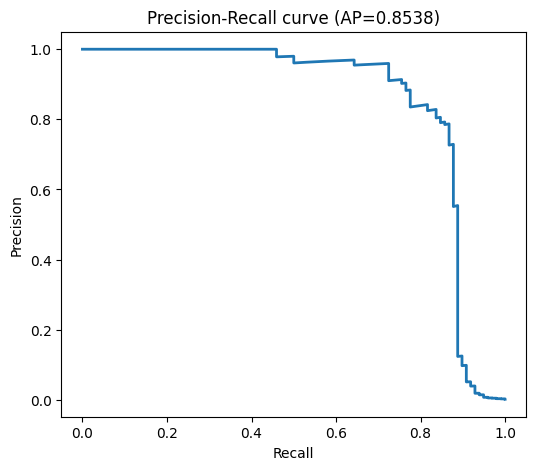

In [46]:
print('\nTraining XGBoost with Stratified KFold...')

def xgb_pr_auc(preds, dtrain):
    labels = dtrain.get_label()
    score = average_precision_score(labels, preds)
    return 'pr_auc', score


xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'verbosity': 0,
}

xgb_oof = np.zeros(len(X_train))
xgb_preds = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'XGBoost Fold {fold+1}/{folds}')
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    watchlist = [(dtrain, 'train'), (dval, 'valid')]

    bst = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=2000,
        evals=watchlist,
        custom_metric=xgb_pr_auc,
        early_stopping_rounds=100,
        verbose_eval=100,
    )

    xgb_oof[val_idx] = bst.predict(dval, iteration_range=(0, bst.best_iteration))
    xgb_preds += bst.predict(dtest, iteration_range=(0, bst.best_iteration)) / folds

# ----- Evaluation -----
roc_oof_xgb = roc_auc_score(y_train, xgb_oof)
ap_oof_xgb = average_precision_score(y_train, xgb_oof)
print(f'XGBoost OOF ROC-AUC: {roc_oof_xgb:.4f}, AP: {ap_oof_xgb:.4f}')

roc_test_xgb = roc_auc_score(y_test, xgb_preds)
ap_test_xgb = average_precision_score(y_test, xgb_preds)
print(f'XGBoost Test ROC-AUC: {roc_test_xgb:.4f}, AP: {ap_test_xgb:.4f}')

# ----- Fraud detection count -----
threshold = 0.5  # can tune this later!
y_pred_labels = (xgb_preds >= threshold).astype(int)

total_frauds = int(y_test.sum())
detected_frauds = int(((y_pred_labels == 1) & (y_test == 1)).sum())
print(f"Frauds detected: {detected_frauds}/{total_frauds} at threshold={threshold}")

# Save XGBoost model
bst.save_model(os.path.join(MODELS_DIR, 'xgboost_full.model'))

# Precision-recall summary
precision_recall_summary(y_test, xgb_preds, plot=True, name='pr_xgb.png')


XGBoost actually performs the worst. We will use LightGBM for final model.

In [47]:
results = {
    'model': ['logistic', 'lightgbm', 'xgboost'],
    'roc_auc': [roc_lr, roc_test, roc_test_xgb],
    'average_precision': [ap_lr, ap_test, ap_test_xgb]
}
results_df = pd.DataFrame(results)
print('\nModel comparison:')
print(results_df)
results_df.to_csv(os.path.join(MODELS_DIR, 'model_comparison.csv'), index=False)

# Save test predictions for later analysis
preds_df = pd.DataFrame({
    'y_true': y_test,
    'proba_logistic': y_pred_proba_lr,
    'proba_lightgbm': lgb_preds,
    'proba_xgboost': xgb_preds,
})
preds_df.to_csv(os.path.join(MODELS_DIR, 'test_predictions.csv'), index=False)

# Save feature columns again
pd.Series(feature_cols).to_csv(os.path.join(MODELS_DIR, 'feature_cols.csv'), index=False)

print('\nAll models and outputs saved to models/ and outputs/')


Model comparison:
      model   roc_auc  average_precision
0  logistic  0.970857           0.718315
1  lightgbm  0.969116           0.837323
2   xgboost  0.976080           0.853813

All models and outputs saved to models/ and outputs/


In [48]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Load predictions
df = pd.read_csv("models/test_predictions.csv")

y_true = df["y_true"]

model_cols = {
    "logistic": "proba_logistic",
    "lightgbm": "proba_lightgbm",
    "xgboost": "proba_xgboost"
}

# Pick a threshold
threshold = 0.5

for model_name, col in model_cols.items():
    # Convert probabilities to binary predictions
    y_pred = (df[col] >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"\n=== {model_name.upper()} ===")
    print(f"Total frauds in test set: {tp + fn}")
    print(f"Frauds correctly predicted (TP): {tp}")
    print(f"Frauds missed (FN): {fn}")
    print(f"False alarms (FP): {fp}")
    print(f"Recall (catch rate): {tp / (tp + fn):.3f}")



=== LOGISTIC ===
Total frauds in test set: 98
Frauds correctly predicted (TP): 90
Frauds missed (FN): 8
False alarms (FP): 1416
Recall (catch rate): 0.918

=== LIGHTGBM ===
Total frauds in test set: 98
Frauds correctly predicted (TP): 86
Frauds missed (FN): 12
False alarms (FP): 40
Recall (catch rate): 0.878

=== XGBOOST ===
Total frauds in test set: 98
Frauds correctly predicted (TP): 60
Frauds missed (FN): 38
False alarms (FP): 2
Recall (catch rate): 0.612


LightGBM and Logistic Regression are close in terms of frauds correctly detected but LightGBM has more than 100x less false positives.